**Autor**: Arthur Raulino Kretzer <br>
**E-mail**: arthur.kretzer@alkimat.com.br <br>

<br>
<hr>

# Avaliação da qualidade de camadas de FLP-L com visão computacional
Este notebook se propõe a identificar a região da peça impressa na foto tirada no equipamento Laserfunde 200 da empresa Alkimat e compará-la a área teórica escaneada pelo laser. O objetivo disto é avaliar a capacidade de monitoramento e controle em tempo real do processo utilizando visão de máquina.
<br>
<br>
<hr>
<br>
Importação das bibliotecas utilizadas no projeto.

In [1]:
import numpy as np
import cv2
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv

from matplotlib.path import Path
from matplotlib.backends.backend_agg import FigureCanvas
from scipy.spatial import distance as dist
from PIL import ImageFile
from skimage import img_as_float, img_as_ubyte, io
from skimage.morphology import opening, closing
from skimage.measure import label, regionprops
from skimage.filters import threshold_yen

ImageFile.LOAD_TRUNCATED_IMAGES = True

Definição de funções úteis para tratamento das imagens.

In [2]:
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")


def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

def warp(filename, bx, by):
    image = filename
    
    #Chose the vertices of the polygon
    tl = (bx[0], by[0])
    bl = (bx[1], by[1])
    tr = (bx[2], by[2])
    br = (bx[3], by[3])

    # load the image, clone it, and initialize the 4 points
    # that correspond to the 4 corners of the chessboard
    pts = np.array([tl, tr, bl, br])

    # loop over the points and draw them on the image
    for (x, y) in pts:
       cv2.circle(image, (x, y), 5, (0, 255, 0), -1)

    # apply the four point tranform to obtain a "birds eye view" of
    # the chessboard
    warped = four_point_transform(image, pts)

    height, width = warped.shape[:2]
    warped = cv2.resize(warped, (width, height))

    return warped

In [3]:
# Creates csv file to store each layer data
csvFile = open("22-11-03_11-12-42/intersection/data.csv", 'w+', encoding='UTF-8')
csv_writer = csv.writer(csvFile)
# File header
csv_writer.writerow(['id', 'intersection_percentage'])

28

Abertura de imagem real da camada

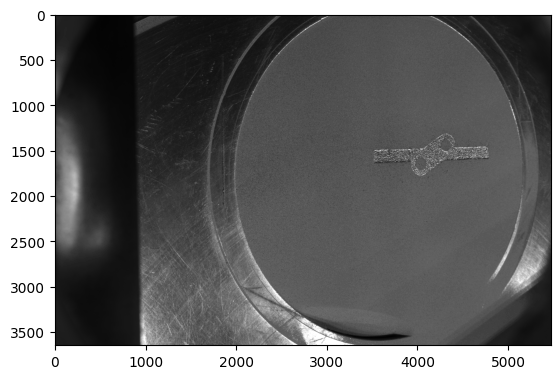

In [4]:
# Opens printed image
printed = io.imread("22-11-03_11-12-42/printed_130.jpg")
plt.imshow(printed, 'gray')

Aplica máscara para isolar a área de impressão

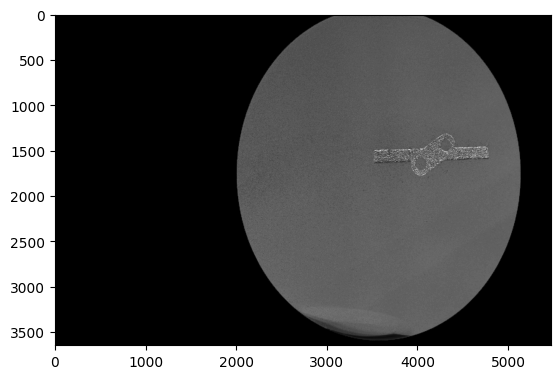

In [5]:
# Mask created manually using GIMP to isolate printing area
mask = io.imread("mask.jpg")
mask = cv2.bitwise_not(mask)
masked = cv2.bitwise_and(printed, printed, mask=mask)
plt.imshow(masked, 'gray')

Vários thresholds foram testados, do mais simples ao mais sofisticado, percebeu-se que o threhold de yen obteve o melhor resultado. Além disso esse threhold pode ser aplicado para imagens com diferentes tipos de matérias-primas que apresentam variação de cores, pois em todos os casos há um contraste que pode ser identificado pela análise do mínimo local do histograma.

<br>

1.Yen J.C., Chang F.J., and Chang S. (1995) “A New Criterion for Automatic Multilevel Thresholding” IEEE Trans. on Image Processing, 4(3): 370-378. DOI:10.1109/83.366472

<br>

2.Sezgin M. and Sankur B. (2004) “Survey over Image Thresholding Techniques and Quantitative Performance Evaluation” Journal of Electronic Imaging, 13(1): 146-165, DOI:10.1117/1.1631315 http://www.busim.ee.boun.edu.tr/~sankur/SankurFolder/Threshold_survey.pdf

<br>

3.ImageJ AutoThresholder code, http://fiji.sc/wiki/index.php/Auto_Threshold

C:\Users\arthu\AppData\Local\Temp\ipykernel_17608\2380962368.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])


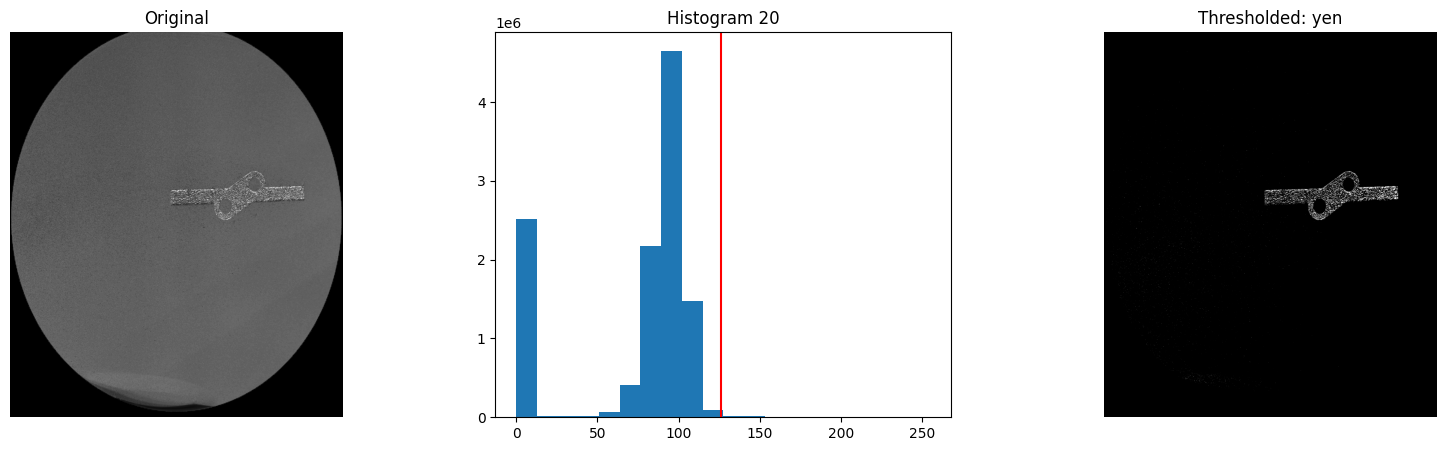

In [6]:
# cuts image just to eliminate black area and to show it better
thresh = threshold_yen(masked[:,1990:5140], 20)
binary = masked > thresh

fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(masked[:,1990:5140], cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(masked[:,1990:5140].ravel(), bins=20)
ax[1].set_title('Histogram '+str(20))
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary[:,1990:5140], cmap=plt.cm.gray)
ax[2].set_title('Thresholded: yen')
ax[2].axis('off')

plt.show()

Aplicaram-se operações de morfologia de abertura e fechamento para remover pixels brancos remanescentes na imagem acima e para gerar uma região conexa na peça. Foram testados diversos tamanhos de kernel de abertura e fechamento até se estabelecer um que atingisse a melhor região conexa.

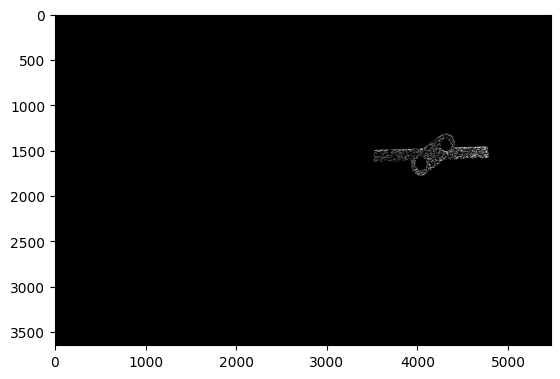

In [7]:
kernel_opening = np.ones((3,3),np.uint8)
opened = opening(binary, kernel_opening)
plt.imshow(opened, 'gray')

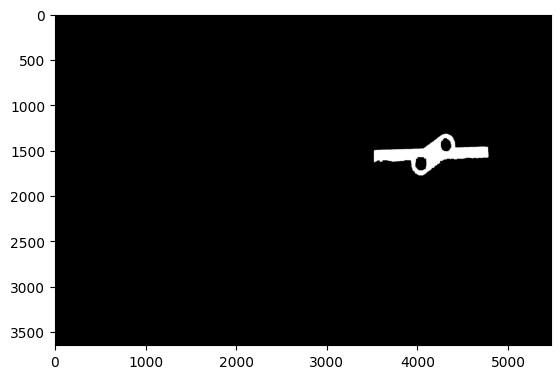

In [8]:
kernel_closing = np.ones((30,30),np.uint8)
closed = closing(opened, kernel_closing)
plt.imshow(closed, 'gray')

A operação de fechamento necessita de um kernel grande para conseguir fechar a região conexa, tornando o processamento relativamente demorado. Esse tempo de processamento começa a ficar crítico, pois deve ficar abaixo de 1 minuto.

<hr>
<br>

A seguir aplicou-se uma correção de angulação da câmera a partir da marcação de um quadrado de referência de 160 mm x 160 mm feito utilizando o laser do equipamento. Essa marcação pode ser muito melhorada para obter-se resultados mais acurados quanto as dimensões dos defeitos e distorções das peças. As coordenadas foram manualmente coletadas abrindo a imagem no GIMP e utilizou-se uma função de warp já implementada neste notebook.

In [9]:
# Square manually got from reference_square.bmp
bx = [2277, 2395, 4827, 4890]
by = [281, 3482, 407, 3107]

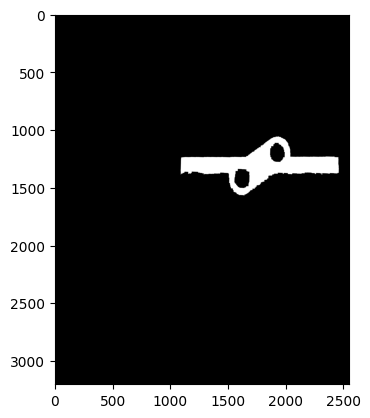

In [10]:
cv_image = img_as_ubyte(closed)
warped_image = warp(cv_image, bx, by)
plt.imshow(warped_image, 'gray')

A imagem está rotacionada 180º em relação ao sistema de coordenadas do equipamento. Dessa forma aplicou-se uma rotação de 180º.

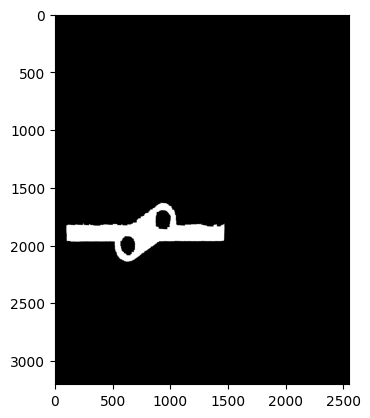

In [11]:
rotated_image = rotate_image(warped_image, 180.0)
plt.imshow(rotated_image, 'gray')

Então identificou-se a a região conexa e extraiu-se a informação de bounding box com as funções do scikit-image

In [12]:
# Convertion from cv format to scikit image format
img = img_as_float(rotated_image)
# Identification of areas
imagem_rotulada = label(img)
# Extraction of areas
regions = regionprops(imagem_rotulada)
# A single region must be found on these images
props = regions[0]
# Bounding box coordinates
minr, minc, maxr, maxc = props.bbox
bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)

A forma mais simples de recortar a imagem e manter o mesmo tamanho em pixels da área escaneada pelo laser que será obtida em sequência foi utilizar também a função de warp, porém utilizando os pontos do bounding box. Para uma maior quantidade de peças em uma mesa de impressão deverá ser feito um trabalho de classificação das peças pelas coordenadas, área e vetores principais.

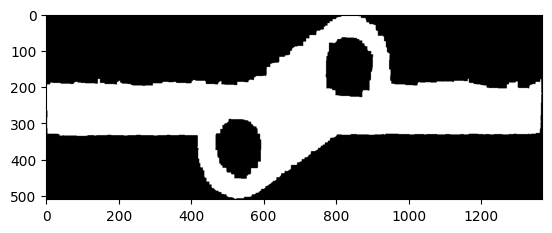

In [13]:
warped_rotated_image = warp(rotated_image, bx, by)
ret, warped_rotated_image = cv2.threshold(warped_rotated_image, 127, 255, cv2.THRESH_BINARY)
plt.imshow(warped_rotated_image, 'gray')

Percebe-se há uma dificuldade em detectar as bordas da peça com precisão. A partir da imagem notou-se que a iluminação gera uma sombra nas bordas da peça, que explicam em partes essa característica. Para melhorar essa detecção serão feitos testes com outra iluminação. Porém, espera-se que a visão computacional não consiga atingir uma precisão muito elevada de detecção e essa margem de erro deverá ser melhor avaliada.
<br>
<hr>
<br>

Em sequência obteve-se a imagem da camada esperada a partir do arquivo de vetores do escaneamento do laser. O arquivo CLI é um formato aberto para impressão 3D e sua documentação pode ser encontrada na internet. Dessa forma não será detalhada a sua rotina de abertura. No equipamento de impressão 3D essa informação já estará carregada em memória e, portanto, será de rápido acesso.

In [14]:
arquivo_cli = open("arquivo.cli", 'r')

Buscam-se as coordenadas do contorno da camada 130 no arquivo CLI.

In [24]:
camada = 130
layer = 0.045
layer_found = False
stop_search = False
#List of contours
polyline = []

#The file is composed of lines separated by a return carriage.
#Readlines returns a list cotaining all those lines as strings.
#This loop sweeps thorugh all lines.
for line in arquivo_cli.readlines():
    #Each line is then separated by words spliting the string empty spaces. 
    #The substrings on this list are named here as part.
    for part in line.split():
        #Checks each substring to identify it's type.
        if '$$UNITS/' in part:
            #This is a conversion value to transform CLI measurement unit to mm.
            unit = float(part[8:])
        elif '$$LAYER/' in part:
            if layer_found:
                #Flag used to stop the for loop.
                stop_search = True
            
            # Computes layer height and compares to desired layer number
            string_layer_height = part[8:]
            layer_height = float(string_layer_height)*unit # mm
            layer_number = int(layer_height/0.045)
            if (camada == layer_number):
                layer_found = True
                print("Camada encontrada!", layer_number)
        
        # This only executes if layer is found and stop search is not enabled.
        elif (('$$POLYLINE/' in part) and layer_found and not stop_search):
            coordinates_only = part[11:]
            #Separates each coordinate by a ','
            tempPolyline = coordinates_only.split(',')
            # Deletes three numbers that indicates ID, Z orientation and number of hatches
            del tempPolyline[0:3]
            # Converts every element from string to float
            tempPolyline = [float(i) for i in tempPolyline]
            #Polylines are divided into groups, in that way there are more than one polyline coordinate list.
            polyline.append(tempPolyline)
    if stop_search:
        break

A partir da identificação das coordenadas de contorno da camada no arquivo CLI, criou-se uma lista de pontos que será utilizada no matplotlib para geração de uma imagem.

In [16]:
#Vertices (X,Y)
verts = []
#Codes 
# Path.MOVETO -> Moves without drawing
# Path.CLOSEPOLY -> Closes (end) the polygon
# Path.LINETO -> Draws a line between two subsequent vertices.
codes = []

for poly in polyline:
    # Transforms each coordinate from CLI measurement unit to mm
    poly = [(i*unit) for i in poly]

    #Coordinates are organized as (x1,y1,x2,y2,...,xn,yn)
    x = 0
    # Sweeps all polyline coordinates with a while loop.
    while x < (len(poly)/2):
        #Builds initial and final coordinates
        vert = (poly[2*x], poly[(2*x)+1])
        verts.append(vert)
        #First vert
        if x == 0:
            codes.append(Path.MOVETO)
        #Final vert
        elif x == ((len(poly)/2)-1):
            codes.append(Path.CLOSEPOLY)
        #All other verts
        else:
            codes.append(Path.LINETO)
        #Increments index x
        x = x + 1

Desenha-se a camada utilizando a matplotlib e uma função PathPatch, que desenha uma linha a partir de instruções de coordenadas. O preenchimento é feito opcionalmente pela função e nesse caso será utilizado.

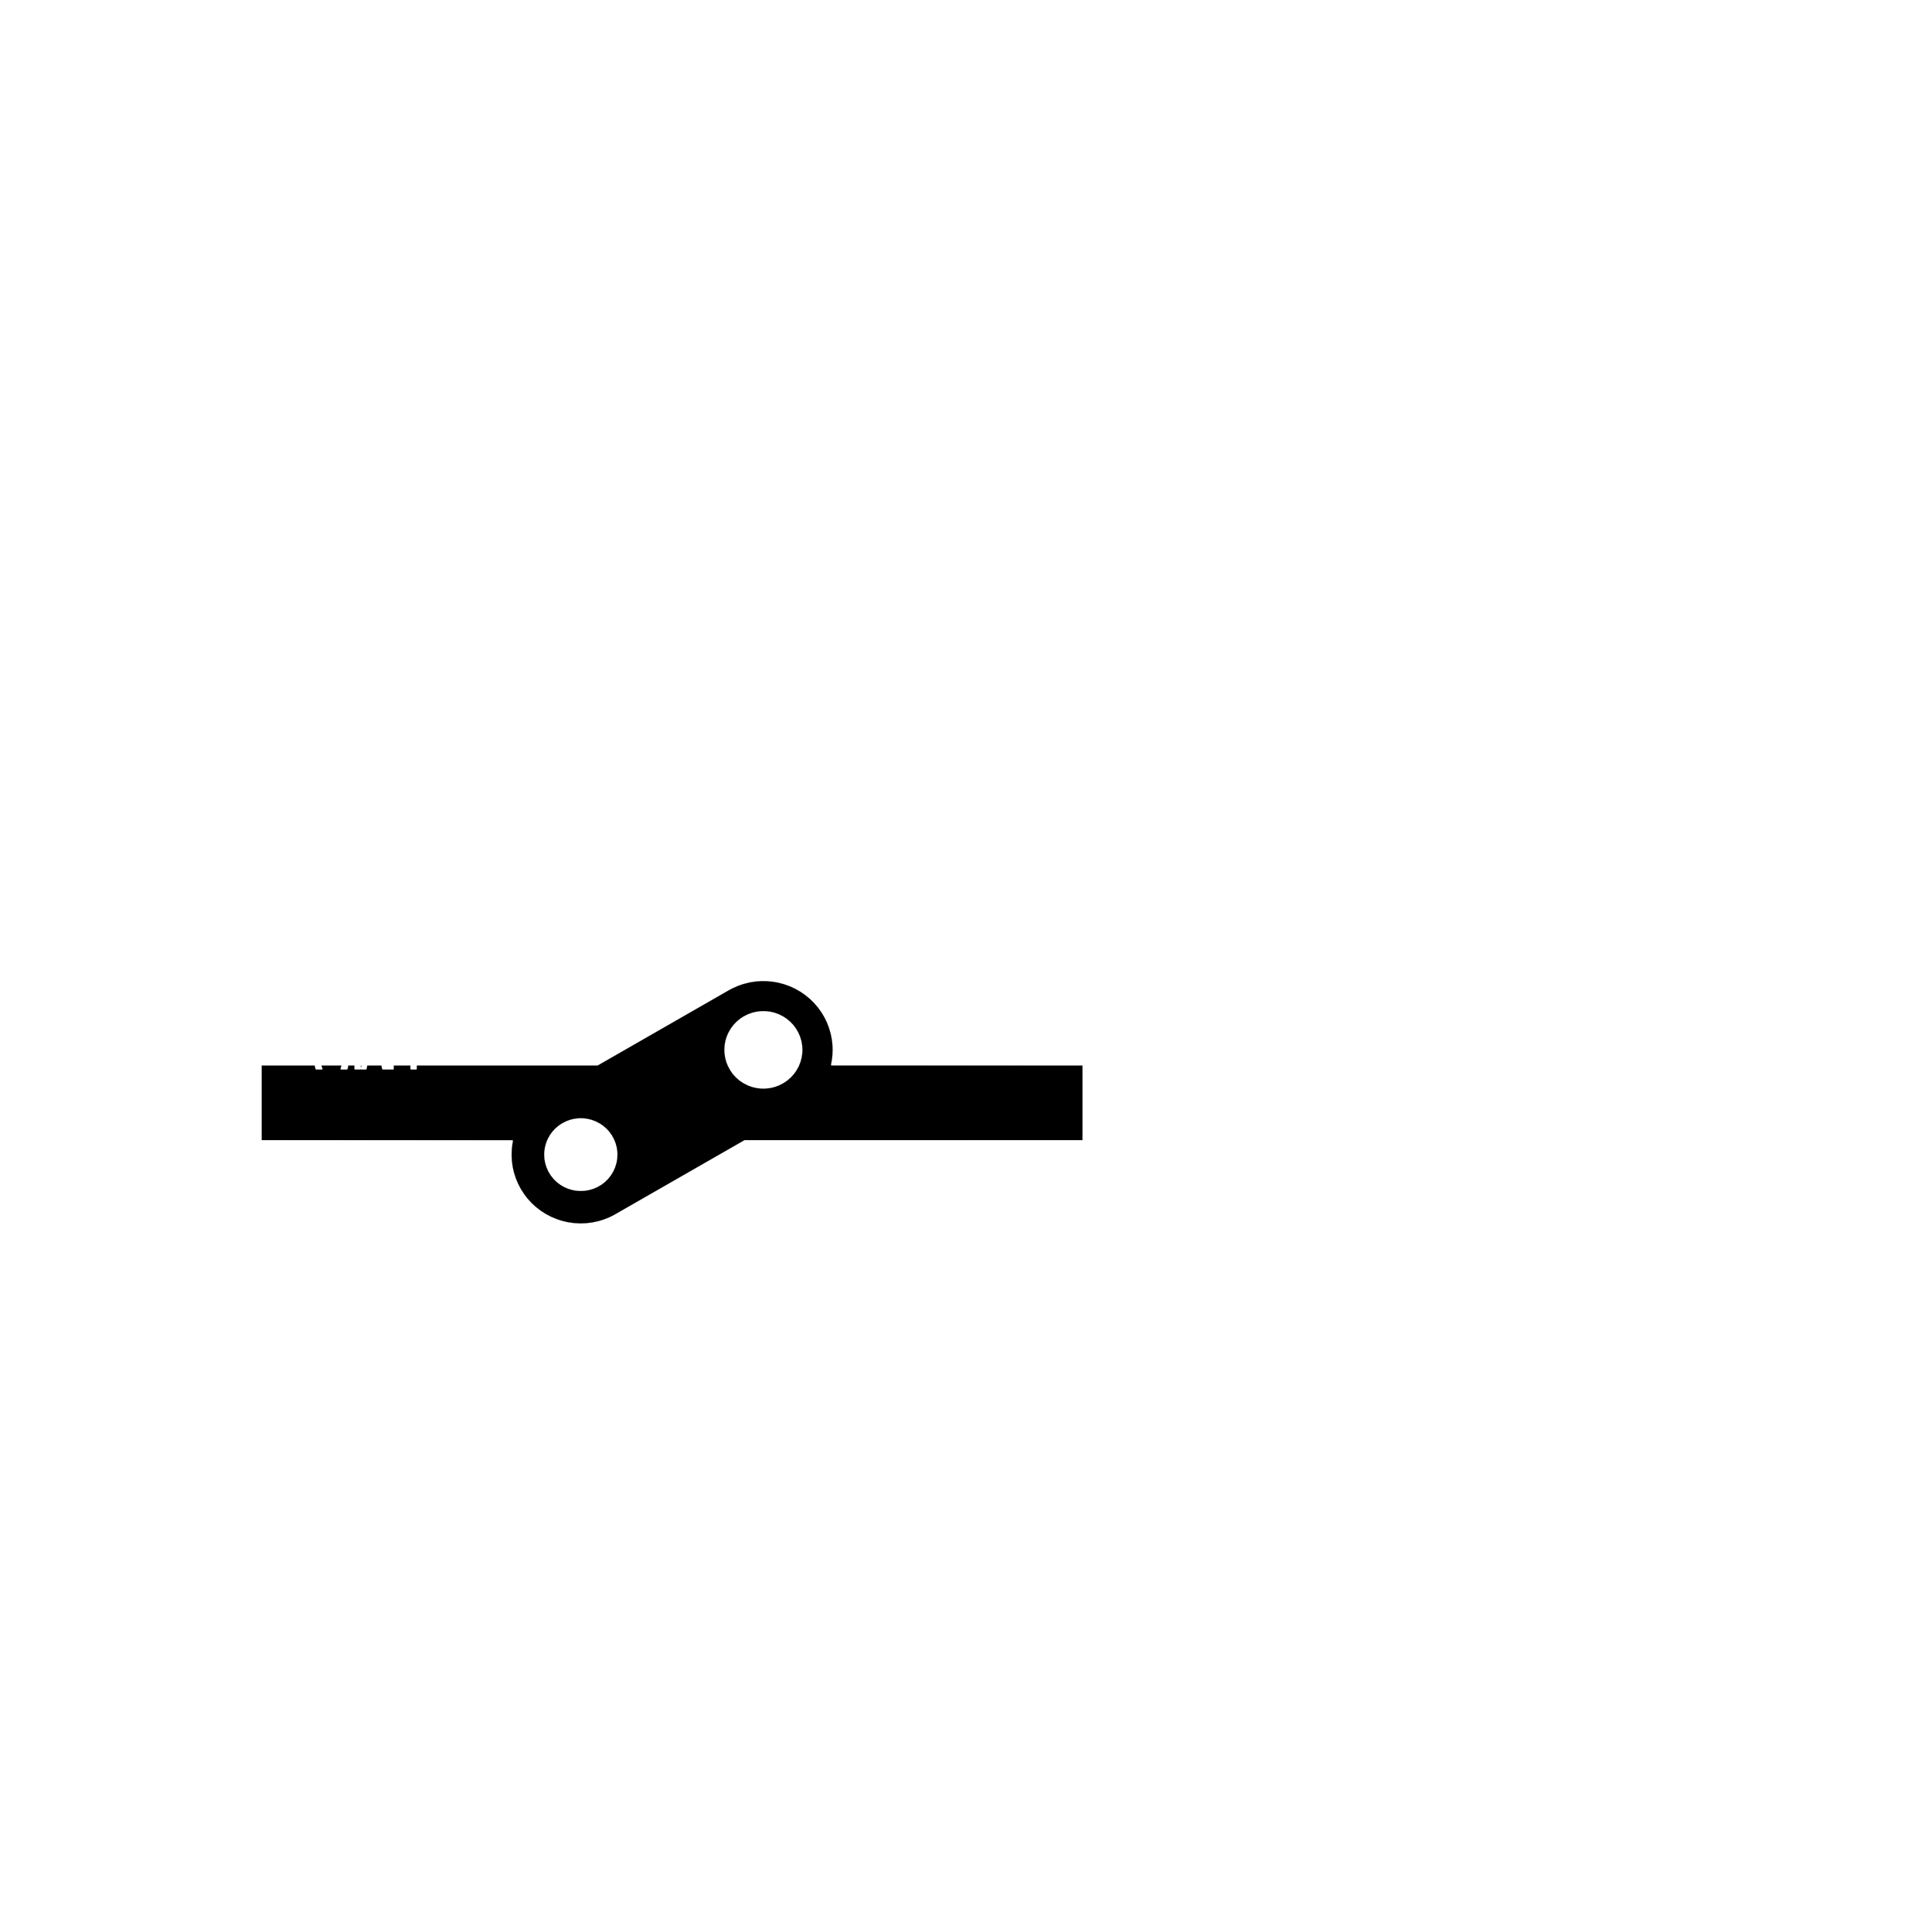

In [17]:
# Final image resolution will be defined by this parameter
matplotlib.rcParams['figure.figsize'] = [32,32]

# Path containing coordinates and their drawing commands
path = Path(verts, codes)

fig, ax = plt.subplots()
#Facecolor is the image filling.
#lw is the countour size. Normaly it is of 0.1mm for the beam spot size of the fiber laser.
patch = patches.PathPatch(path, facecolor='black', lw=0.1)
ax.add_patch(patch)
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
#Ignores axis to have a cleaner image
plt.axis('off')
#===============================================
# convert it to an OpenCV image/numpy array
canvas = FigureCanvas(fig)
canvas.draw()
# convert canvas to image
layer_image = np.array(fig.canvas.get_renderer()._renderer)
# it still is rgb, convert to opencv's default bgr
layer_image = cv2.cvtColor(layer_image,cv2.COLOR_RGB2GRAY)
#===============================================

Para realizar operações entre essa imagem e a binarizada, inverte-se as suas cores. Além disso, o arquivo CLI carregado foi projetado para uma área de 200 mm x 200 mm, porém reduziu-se esta área para 160 mm x 160 mm para condizer com a imagem real após a função de warp.

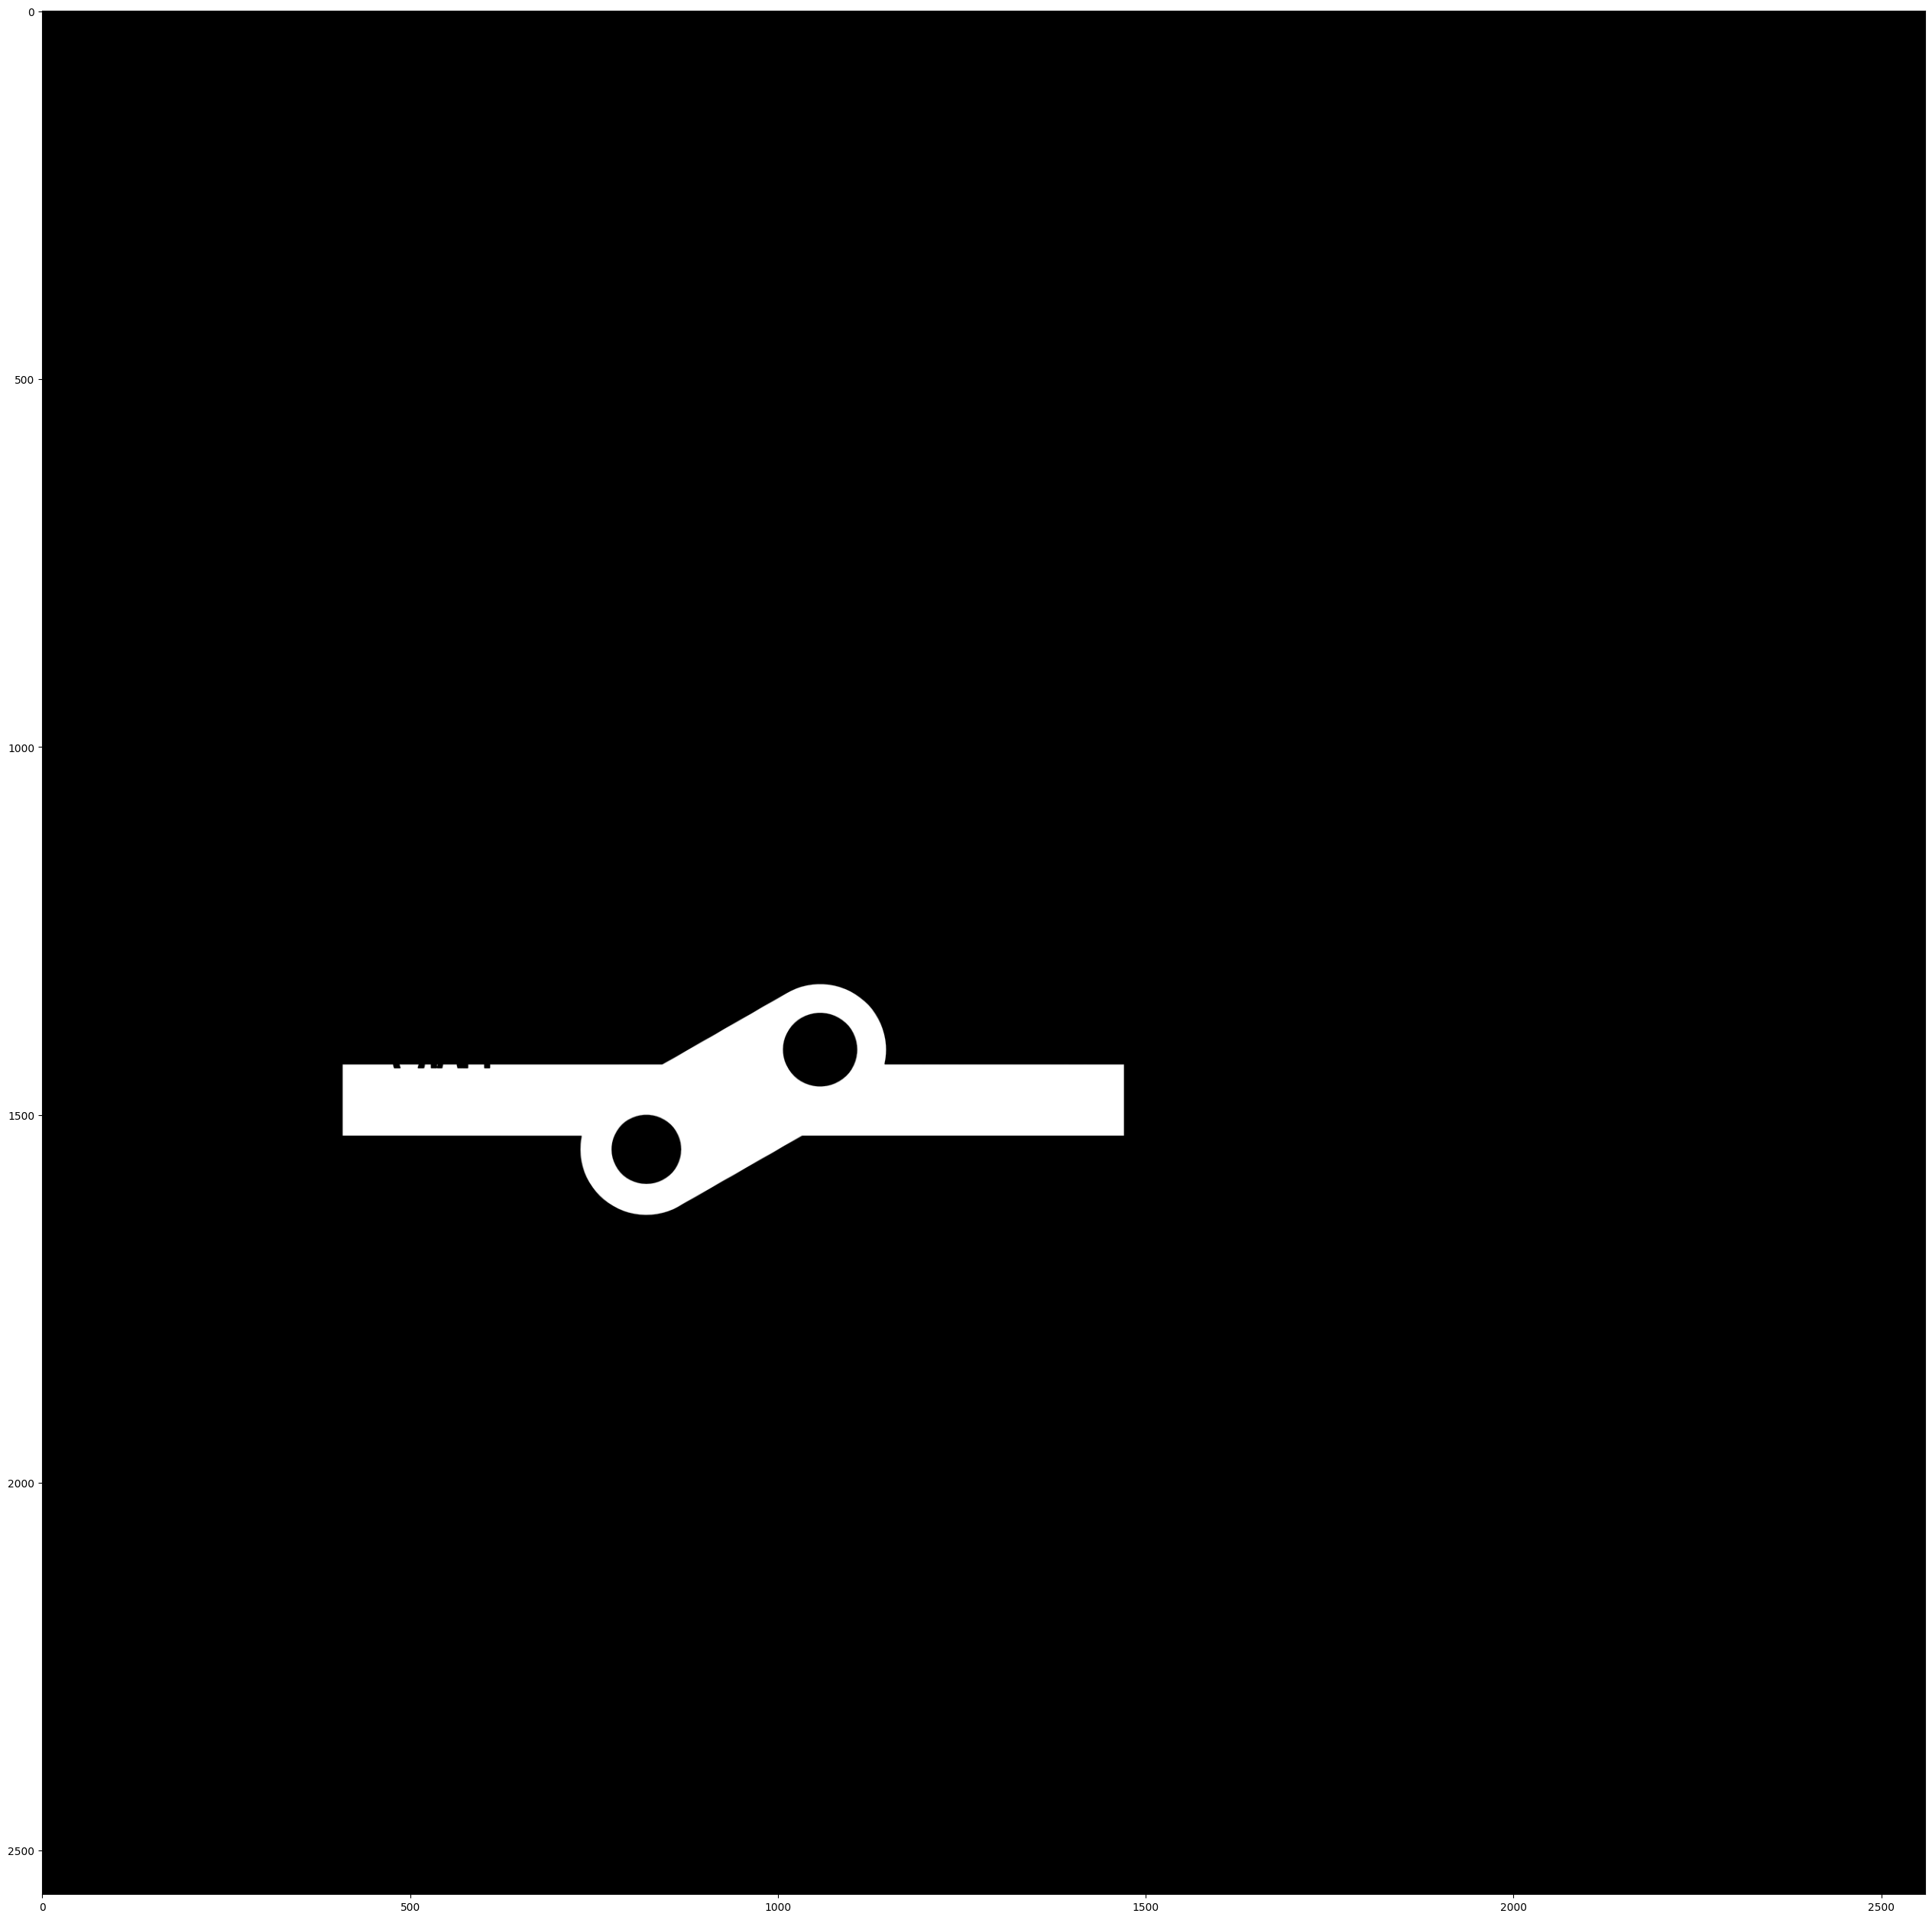

In [18]:
layer_image = cv2.bitwise_not(layer_image)
# Redimensionando a área de 160 x 160 mm
layer_image = layer_image[320:2880, 320:2880]
plt.imshow(layer_image, 'gray')

Da mesma forma que anteriormente, aplicou-se o warp com o bounding box para que a imagem resultante possa ser sobreposta sobre a imagem real. Mesmo assim foi necessário aplicar um redimensionamento da imagem para condizer a resolução final. 

In [19]:
# Convert cv format to scikit-image format
img = img_as_float(layer_image)
# Identification of areas
imagem_rotulada = label(img)
# Extraction of areas
regions = regionprops(imagem_rotulada)
# A single region must be found on these images
props = regions[0]
# Bounding box coordinates
minr, minc, maxr, maxc = props.bbox
bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)

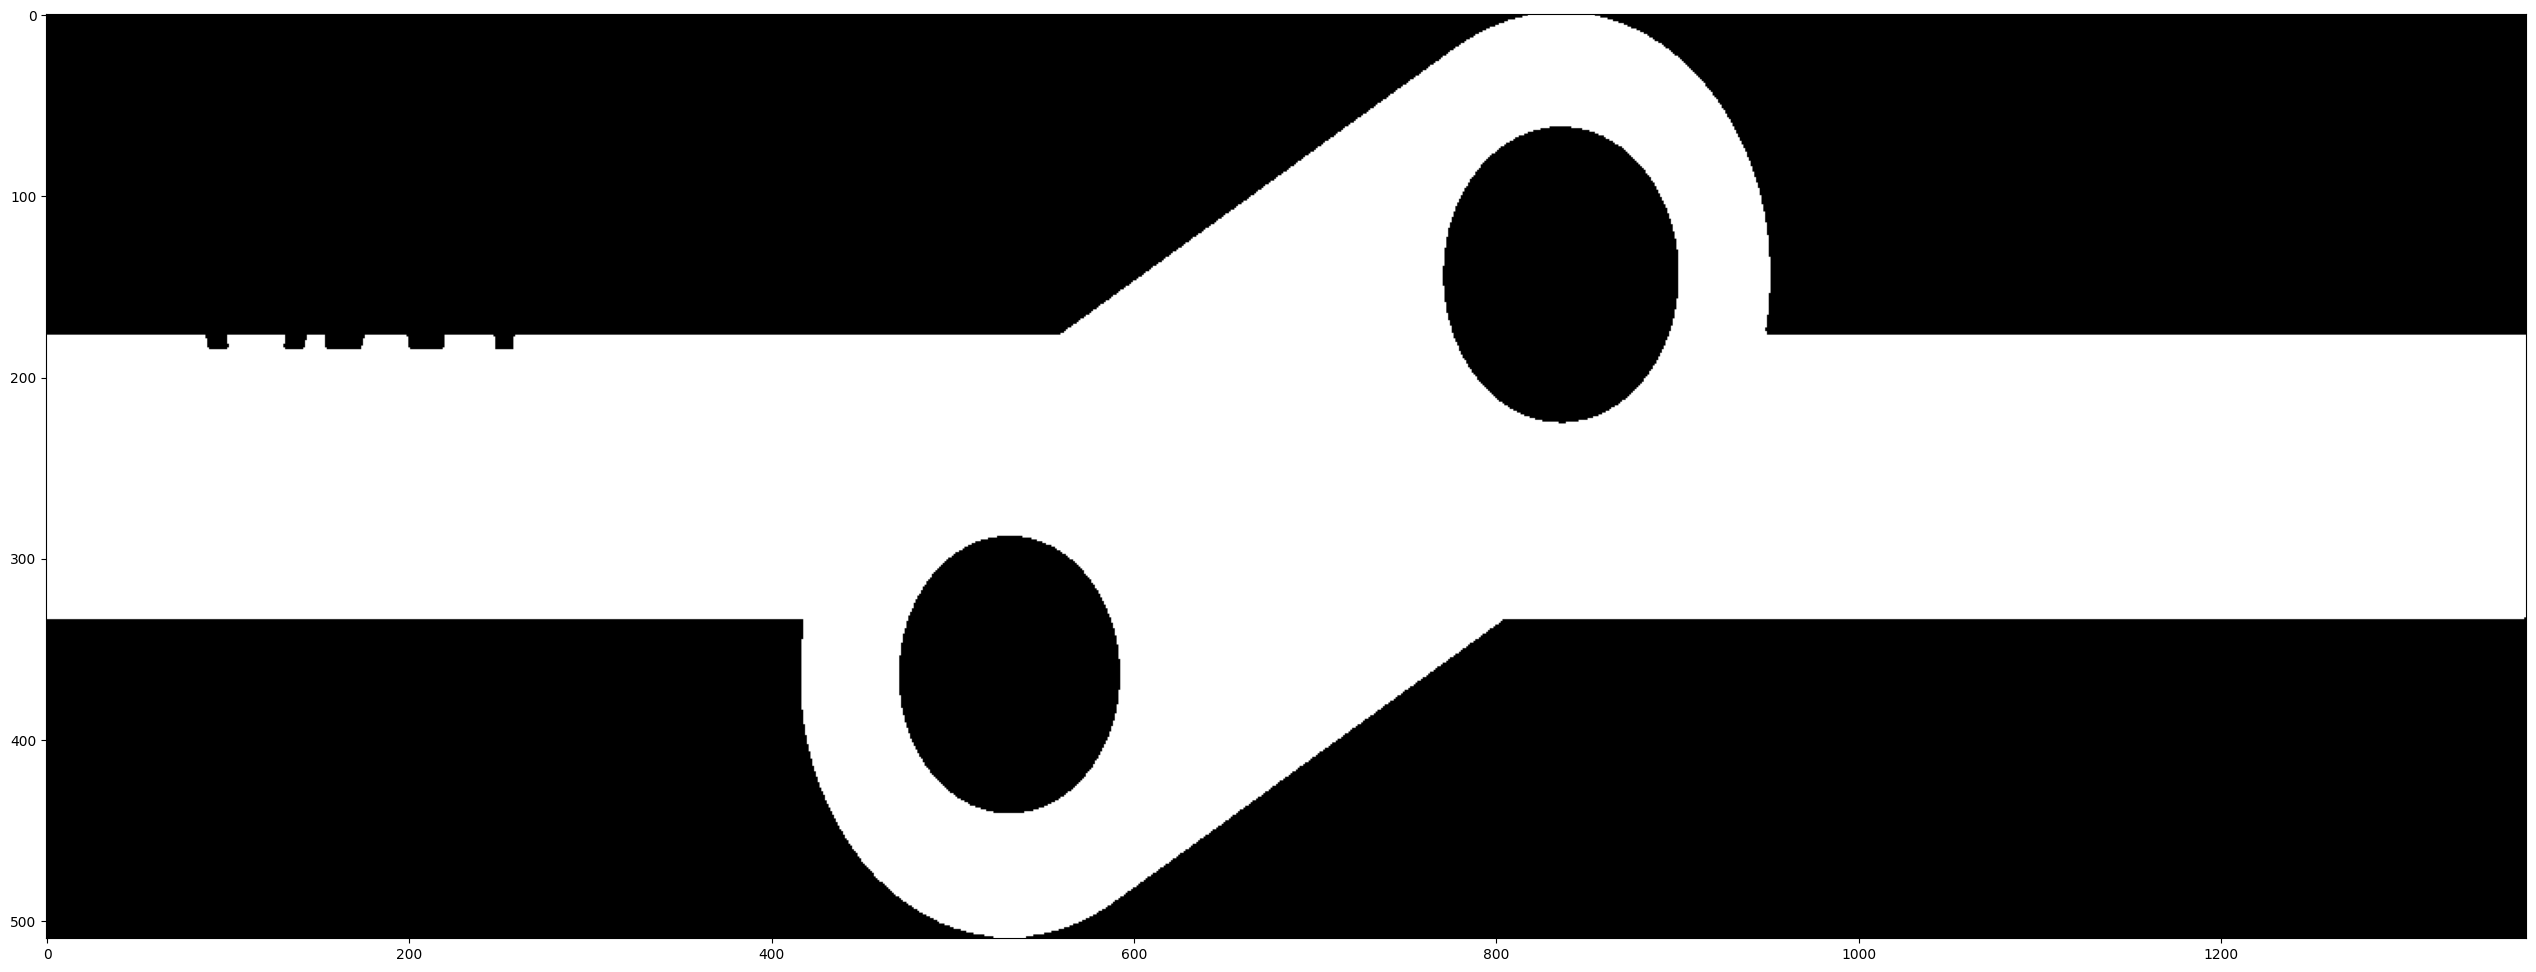

In [20]:
warped_layer_image = warp(layer_image, bx, by)
# Resize to achieve same resolution as real image
warped_layer_image = cv2.resize(warped_layer_image,(warped_rotated_image.shape[1],warped_rotated_image.shape[0]),None,None,cv2.INTER_LINEAR)
# Threshold to remove "fading" pixels after resize.
ret, warped_layer_image = cv2.threshold(warped_layer_image, 127, 255, cv2.THRESH_BINARY)
plt.imshow(warped_layer_image, 'gray')


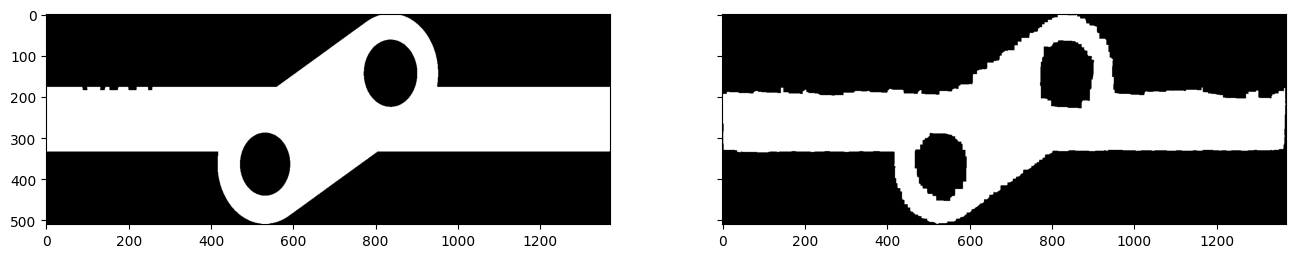

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(warped_layer_image,'gray')
ax[1].imshow(warped_rotated_image,'gray')

Optou-se comparar as duas imagens a partir da lógica "ou exclusivo" em que só as diferenças são ressaltadas.

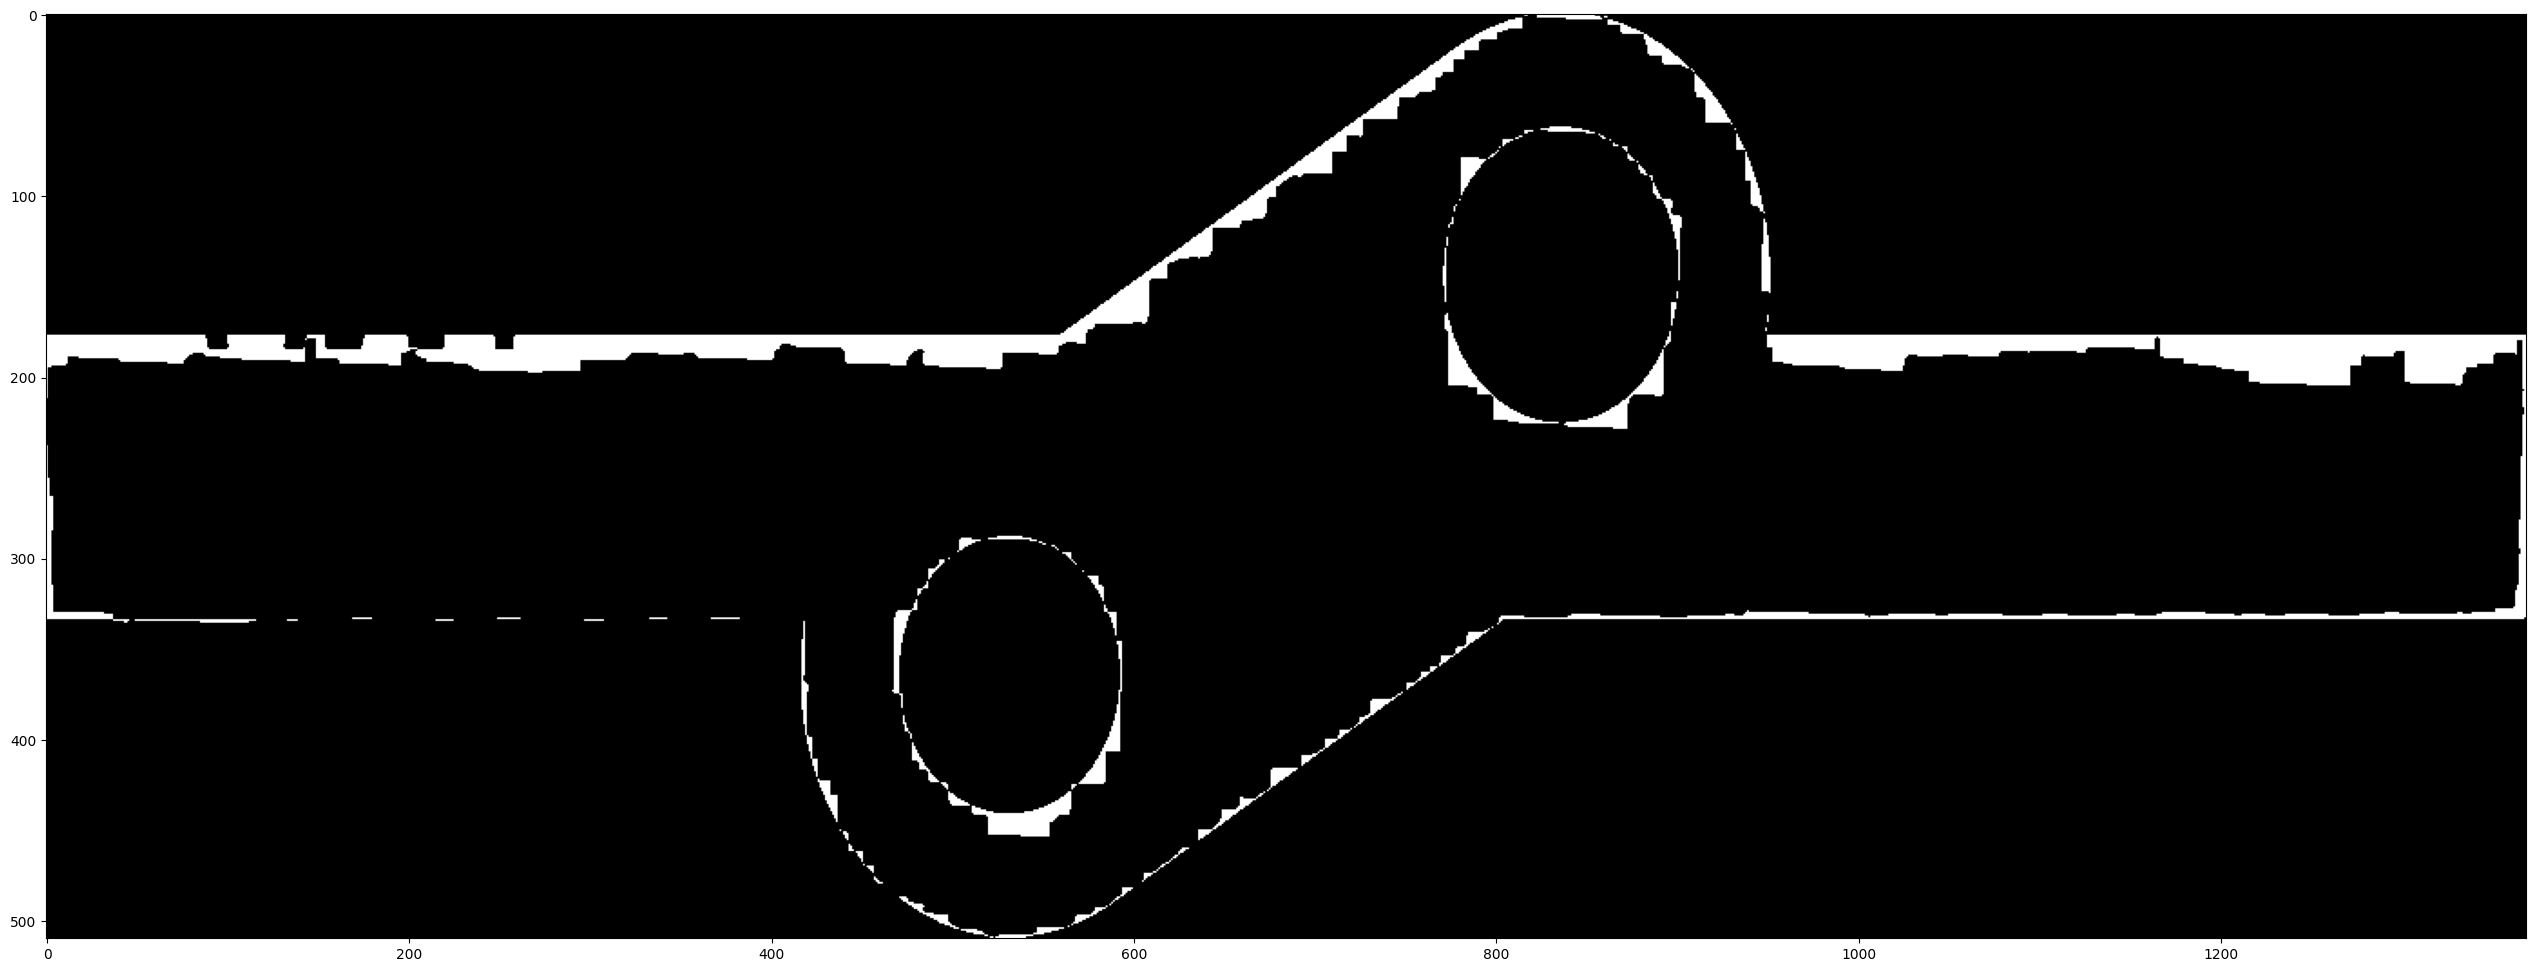

In [22]:
result = cv2.bitwise_xor(warped_layer_image, warped_rotated_image)
cv2.imwrite('22-11-03_11-12-42/intersection/intersection_printed_130.jpg', result)
plt.imshow(result, 'gray')

A comparação final é feita calculando a área em pixels da diferença das imagens sobre a área em pixel da imagem teórica obtida do arquivo CLI, resultado em um valor percentual de semelhança.

In [23]:
white_pixels_layer_image = np.sum(warped_layer_image == 255)
white_pixels_layer_result = np.sum(result == 255)
percentage = (white_pixels_layer_result/white_pixels_layer_image)*100
print("Diferença entre arquivo e imagem é de ", round(percentage, 2),'%')
csv_writer.writerow(['130', str(percentage)])

Diferença entre arquivo e imagem é de  8.98 %


23